
# Creacion de Modelo para Sigmahacks

Diagnóstico de Covid19 mediante clasificación de imágenes de RX de Tórax aplicando Transfer Learning

Las bases de datos fueron obtenidas de: https://github.com/ieee8023/covid-chestxray-dataset.git y https://data.mendeley.com/datasets/rscbjbr9sj/2



# Importando Paquetes necesarios y visualizando imágenes

*Estableciendo Tensorflow 1.x:*

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Montando Google Drive:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Visualizando imágenes del dataset:**

Using TensorFlow backend.


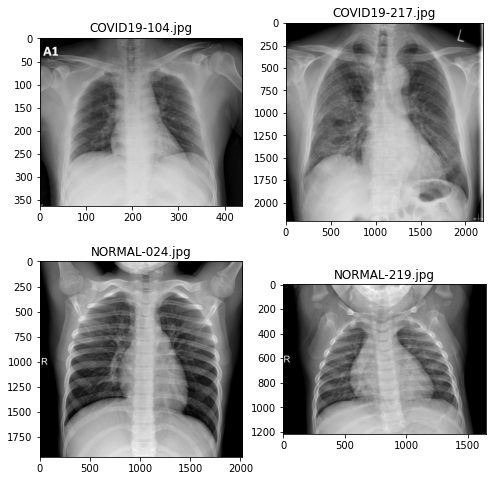

In [ ]:
#Importación de paquetes necesarios
import os
import shutil
import glob
import numpy as np
from random import randrange

from keras.preprocessing import image
import matplotlib.pyplot as plt

# Carpeta del proyecto
project_folder = "/content/drive/MyDrive/COVID-19 DenseNet"

#Con glob leemos el contenido de las carpetas
files_train_covid19 = glob.glob(project_folder+"/dataset/train/covid19/*.jpg")
files_test_covid19 = glob.glob(project_folder+"/dataset/test/covid19/*.jpg")
files_train_normal = glob.glob(project_folder+"/dataset/train/normal/*.jpg")
files_test_normal = glob.glob(project_folder+"/dataset/test/normal/*.jpg")

# Obteniendo imágenes al azar de cada carpeta
file_train_covid19 = files_train_covid19[randrange(len(files_train_covid19))]
image_train_covid19 = image.load_img(file_train_covid19)

file_test_covid19 = files_test_covid19[randrange(len(files_test_covid19))]
image_test_covid19 = image.load_img(file_test_covid19)

file_train_normal = files_train_normal[randrange(len(files_train_normal))]
image_train_normal = image.load_img(file_train_normal)

file_test_normal = files_test_normal[randrange(len(files_test_normal))]
image_test_normal = image.load_img(file_test_normal)

# Mostrar las imagenes obtenidas al azar
fig = plt.gcf()
fig.set_size_inches(8, 8)

plt.subplot(2,2,1)
plt.imshow(image_train_covid19)
plt.title(file_train_covid19.split("/")[-1])

plt.subplot(2,2,2)
plt.imshow(image_test_covid19)
plt.title(file_test_covid19.split("/")[-1])

plt.subplot(2,2,3)
plt.imshow(image_train_normal)
plt.title(file_train_normal.split("/")[-1])

plt.subplot(2,2,4)
plt.imshow(image_test_normal)
plt.title(file_test_normal.split("/")[-1])

plt.show()


 ## **PREPROCESAMIENTO DE DATOS**
---

**Cargar dataset TRAIN y aplicar Data Augmentation:**

In [ ]:
#Importar ImageDataGenerator para aplicar Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

# Dimensión de las imágenes para Densenet
img_width = 224
img_height = 224
batch_size = 40

# Definir las caracteristicas para Data Augmentation y Normalization
datagen_train = ImageDataGenerator(rescale=1.0/255.0,      # Normalizar los valores al rango [0-1]
                                   horizontal_flip=True,   # Giro horizontal
                                   rotation_range=15,      # Giro aleatorio (clockwise) entre 0 y 15 grados
                                   width_shift_range=0.15,  # Mover la img horizontelmente 15%
                                   height_shift_range=0.15, # Mover la img verticalmente 15%
                                   zoom_range=0.2)          # Zoom in / Zoom out aleatorio de 20% => 80% - 120%

# Leer imagenes de la carpeta entrenamiento
training_set_imgs = datagen_train.flow_from_directory(project_folder+"/dataset/train",
                                                      target_size = (img_width, img_height),
                                                      class_mode = 'binary',
                                                      classes = ['normal','covid19'],
                                                      batch_size = batch_size)

# Mostrando resultados
num_imgs_training = len(training_set_imgs.filenames)

print("\n")
print("Núm. de imgs ENTRENAMIENTO:", num_imgs_training)
print("Classes:", training_set_imgs.class_indices)
print("Núm. Classes [0]:", np.sum(training_set_imgs.labels == 0, axis=0))
print("Núm. Classes [1]:", np.sum(training_set_imgs.labels == 1, axis=0))

Found 352 images belonging to 2 classes.


Núm. de imgs ENTRENAMIENTO: 352
Classes: {'normal': 0, 'covid19': 1}
Núm. Classes [0]: 176
Núm. Classes [1]: 176


**Mostrando datos resultado de Data augmentation:**

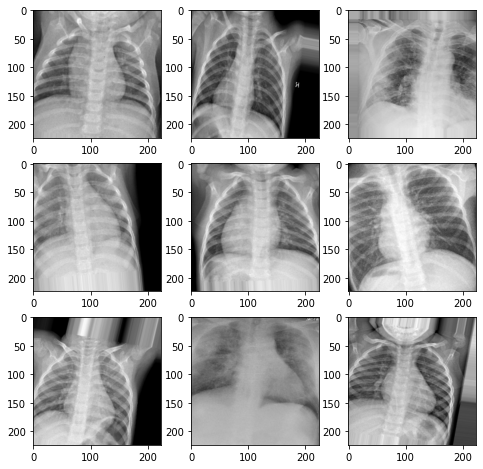

In [ ]:
import copy 

# Visualizando data augmentation para 1 imagen
fig = plt.gcf()
fig.set_size_inches(8, 8)

it = copy.copy(training_set_imgs)

for i in range(9):
	plt.subplot(3,3,1 + i)
	batch = it.next()[0]
	imagenp = (batch[0]*255).astype('uint8')
	plt.imshow(imagenp)
plt.show()

**Cargar dataset TEST sin aplicar Data Augmentation:**

In [ ]:
# Data Normalization
datagen_test = ImageDataGenerator(rescale=1.0/255.0)

# Leer imagenes del folder dataset/train
testing_set_imgs = datagen_test.flow_from_directory(project_folder+"/dataset/test",
                                                      target_size = (img_width, img_height),
                                                      class_mode = 'binary',
                                                      classes = ['normal','covid19'],
                                                      batch_size = batch_size,
                                                      shuffle=False) #Organizar datos
# Mostrando resultados
num_imgs_testing = len(testing_set_imgs.filenames)

print("\n")
print("Núm. de imgs TEST:", num_imgs_testing)
print("Classes:", testing_set_imgs.class_indices)
print("Núm. Classes [0]:", np.sum(testing_set_imgs.labels == 0, axis=0))
print("Núm. Classes [1]:", np.sum(testing_set_imgs.labels == 1, axis=0))

Found 88 images belonging to 2 classes.


Núm. de imgs TEST: 88
Classes: {'normal': 0, 'covid19': 1}
Núm. Classes [0]: 44
Núm. Classes [1]: 44


## **CONSTRUYENDO LA RED NEURONAL ARTIFICIAL (CNN) - ARQUITECTURA**
---

**Cargar Modelo pre-entrenado DenseNet:**

In [ ]:
# DenseNet https://keras.io/api/applications/densenet/
# https://towardsdatascience.com/paper-review-densenet-densely-connected-convolutional-networks-acf9065dfefb
from keras.applications import DenseNet201
# ResNet https://keras.io/api/applications/resnet/
# from keras.applications import ResNet152V2

# Instancia de DenseNet utilizando los parametros a partir de imagenet
pretrained_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

pretrained_model.summary();

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


74842112/74836368 [==============================] - 1s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 

**Congelar (freeze) los params en el Feature Extractor:**

In [ ]:
#Iterar cada capa de convolución y que no sea entrenable
for layer in pretrained_model.layers:
    layer.trainable = False

pretrained_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

**Clasificador Propio**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dropout

# Definiendo una Red Neuronal vacía
model = Sequential()

# Agregando la parte convolucional (base)
model.add(pretrained_model)               # Modelo base

# Clasificador propio
# GlobalAveragePooling2D https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
model.add(GlobalAveragePooling2D())  
# Capa de clasificación con ReLu    
model.add(Dense(1000, activation='relu'))
# Capa para evitar el outver
model.add(Dropout(rate=0.2))
# Umbral
model.add(Dense(1, activation='sigmoid'))

print("Arquitectura final de la CNN:")
model.summary()

Arquitectura final de la CNN:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1921000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 20,243,985
Trainable params: 1,922,001
Non-trainable params: 18,321,984
_________________________________________________________________


## **ENTRENANDO LA RED NEURONAL ARTIFICIAL CNN**
---

**Compilar la Red Neuronal Convolucional:**

In [ ]:
from keras.optimizers import SGD
from keras.optimizers import Adam

# Gradiente Descendiente Estocasica
opt = SGD(lr=0.008, momentum=0.9)
# opt = Adam(lr=0.008, beta_1=0.9, beta_2=0.999)

# Compilación de la Red Neuronal Convolucional
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) # En cada iteración medir la precisión del modelo

**Entrenar la Red Neuronal convolucional:**

In [ ]:
%%time

epochs=20

# Entrenar con fit_generator(serie de imagenes, epocas = 20, serie de pasos calculados por cada epoca / lote)
historial = model.fit_generator(training_set_imgs,
                              epochs=epochs,
                              steps_per_epoch=np.ceil(num_imgs_training/batch_size),
                              validation_data=testing_set_imgs,
                              validation_steps=np.ceil(num_imgs_testing/batch_size)) 


Epoch 1/20
9/9 [==============================] - 30s 3s/step - loss: 0.4460 - accuracy: 0.8182 - val_loss: 0.1025 - val_accuracy: 0.9205
Epoch 2/20
9/9 [==============================] - 10s 1s/step - loss: 0.2137 - accuracy: 0.9176 - val_loss: 0.0334 - val_accuracy: 0.9318
Epoch 3/20
9/9 [==============================] - 15s 2s/step - loss: 0.1135 - accuracy: 0.9574 - val_loss: 0.0365 - val_accuracy: 1.0000
Epoch 4/20
9/9 [==============================] - 15s 2s/step - loss: 0.1029 - accuracy: 0.9545 - val_loss: 0.1357 - val_accuracy: 0.9545
Epoch 5/20
9/9 [==============================] - 15s 2s/step - loss: 0.0395 - accuracy: 0.9915 - val_loss: 0.0427 - val_accuracy: 0.9773
Epoch 6/20
9/9 [==============================] - 15s 2s/step - loss: 0.0739 - accuracy: 0.9801 - val_loss: 0.0636 - val_accuracy: 0.9659
Epoch 7/20
9/9 [==============================] - 15s 2s/step - loss: 0.0531 - accuracy: 0.9830 - val_loss: 0.0803 - val_accuracy: 0.9659
Epoch 8/20
9/9 [=================

**Graficar resultados del entrenamiento:**

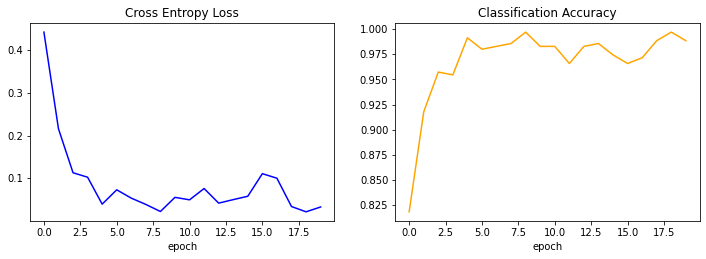

In [ ]:
# Aquí graficamos los resultados obtenidos
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(12, 8)

# plot loss
plt.subplot(2,2,1)
plt.title('Cross Entropy Loss')
plt.xlabel("epoch")
#Obtener la variable loss
plt.plot(historial.history['loss'], color='blue', label='train')

# plot accuracy
plt.subplot(2,2,2)
plt.title('Classification Accuracy')
plt.xlabel("epoch")
#Accuracy
plt.plot(historial.history['accuracy'], color='orange', label='train')

## **EVALUANDO LA RED NEURONAL CONVOLUCIONAL (CNN)**
---

**Evaluación vía 'evaluate_generator':**

In [ ]:
# Accuraccy del Test (Usar este valor como referencial solamente https://github.com/keras-team/keras/issues/6499)
eval = model.evaluate_generator(testing_set_imgs, steps=np.ceil(num_imgs_testing/batch_size))

# Mostrar los resultados
print('\nValidación en Test:')
print("Loss: {:.4}".format(eval[0]))
print("Accuracy: {:.2%}".format(eval[1]))


Validación en Test:
Loss: 0.03632
Accuracy: 97.73%


**Evaluación vía 'predict_generator' y Matriz de Confusión:**

In [ ]:
# Matriz de Confusión
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# Umbral de 0.5, para obtener metricas adecuadas
THRESHOLD=0.5
testing_set_imgs.reset() #batch_index=0

# Llamamos al método predict_generator
Y_pred = model.predict_generator(testing_set_imgs, steps=np.ceil(num_imgs_testing/batch_size))
y_pred = np.where(Y_pred >= THRESHOLD, 1, 0)
# print(Y_pred)
# print(y_pred)

# Calcular la matrix de confusión 
cm = confusion_matrix(testing_set_imgs.classes, y_pred)
print("\nMatriz de Confusión:\n")
print(cm)

# print('\nClassification Report:')
# classes_names = ['normal', 'covid19']
# print(classification_report(testing_set_imgs.classes, y_pred, target_names=classes_names))


Matriz de Confusión:

[[44  0]
 [ 2 42]]


**Visualizando la Matriz de Confusión:**

Matriz de Confusión sin Normalizar


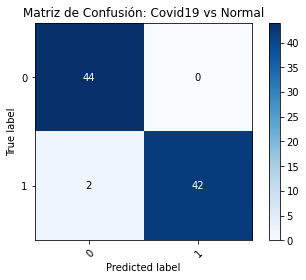

In [ ]:
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

# Función para graficar la matrix de confusión para interpretarla de mejor manera
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Matriz de Confusión Normalizada'
        else:
            title = 'Matriz de Confusión sin Normalizar'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusión Normalizada")
    else:
        print('Matriz de Confusión sin Normalizar')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(linewidth=.0)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    plt.show()
    return ax


plot_confusion_matrix(testing_set_imgs.classes, y_pred, normalize=False,title="Matriz de Confusión: Covid19 vs Normal")

**Métricas de la Matriz de Confusión:**

In [ ]:
# Métricas (https://en.wikipedia.org/wiki/Confusion_matrix)
TN, FP, FN, TP = cm.ravel()

# Realizar los calculos de las métricas
exactitud = (TP + TN)/(TP + TN + FN + FP)
sensitividad = TP / (TP + FN)
especificidad = TN / (TN + FP)
prevalencia = np.sum(testing_set_imgs.classes)/len(testing_set_imgs.classes)

print("\nMétricas:\n")
print("Exactitud: {:.2%}".format(exactitud))
print("Sensitividad: {:.2%}".format(sensitividad))
print("Especificidad: {:.2%}".format(especificidad))
print("Prevalencia: {:.2%}".format(prevalencia))

# ROC Curve
AUC = roc_auc_score(testing_set_imgs.classes, y_pred)
print("AUCROC: {:.2%}".format(AUC))


Métricas:

Exactitud: 97.73%
Sensitividad: 95.45%
Especificidad: 100.00%
Prevalencia: 50.00%
AUCROC: 97.73%


## **GUARDANDO LA RED NEURONAL CONVOLUCIONAL EN DISCO**
---

**Guardando modelo en disco:**

In [ ]:
# Guardando Arquitectura y Pesos como archivos diferentes
# Opcional (Evaluando para llevarlo a campo)
model_json = model.to_json()
with open(project_folder + "/output/covid19_model_config.json","w") as json_file:
  json_file.write(model_json)

model.save_weights(project_folder + "/output/covid19_model_weights.h5")
print("El modelo se ha guardado en disco")

El modelo se ha guardado en disco


In [ ]:
# Cuardando como un único archivo
model.save(project_folder + "/output/ramseths_model_full.h5")
print("El modelo se ha guardado en disco")

El modelo se ha guardado en disco


## **CARGANDO LA RED NEURONAL ARTIFICIAL EN DISCO Y REALIZANDO PREDICCIONES**
---

**Cargando modelo de disco:**

In [ ]:
# Cargando modelo desde el disco
from keras.models import load_model
# Cargar el modelo
loaded_model = load_model(project_folder + "/output/ramseths_model_full.h5")
# Resumen del modelo
loaded_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1921000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 20,243,985
Trainable params: 1,922,001
Non-trainable params:

**Realizando predicciones:**

Image type: <class 'PIL.Image.Image'>
Image size: (224, 224)


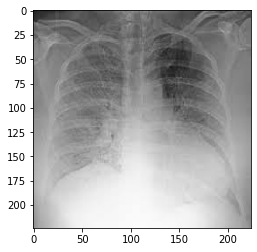

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import urllib.request

# Cargando imagen a predecir: 
# https://radiologyassistant.nl/chest/covid-19-ct-findings-in-25-patients
# URL_image_rx_test = 'https://radiologyassistant.nl/assets/x.jpg'
# http://www.meddean.luc.edu/lumen/meded/medicine/pulmonar/cxr/atlas/cxratlas_f.htm
URL_image_rx_test = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxITEhUTExMVFhUXFxgXFxUYFxcXFxcZFxcXFxcXGB0YHSggHR0lGxcVITEiJSkrLi4uFx8zODMtNygtLisBCgoKBQUFDgUFDisZExkrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrK//AABEIAM4A9QMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAADBAECBQAGB//EADYQAAEDAgQDBgUFAAIDAQAAAAEAAgMRIQQxQVESYXETgZGh0fAFIjKxwRRCUuHxYoJTkvIz/8QAFAEBAAAAAAAAAAAAAAAAAAAAAP/EABQRAQAAAAAAAAAAAAAAAAAAAAD/2gAMAwEAAhEDEQA/APmccaOzD10Xp4/g0YLnNdrZrgCBqrfpqZxh3Nor5BB55uECa/Tt4e4fcLdZC3/xN8CmhCKf/nHlsN0Hm4ogE3CxbbYW/wAIj/1A+yHNgYz+0t5tJp4ZIMxxpkgvyTM2Ac27TxDwKABe/ggC1xGSZZOqhqqIzWgFUDDZSmoMQRZLRRWqUaK23ig0YZHZm4KaaaDOhzp681mseXDL8BM9m/hu+mzaA1CAeIxTqkI4c6lQRdISkcVCRXoi9oQB4IIfO7xJI+yXfMRZTMS4hS8XQBGKJQ3zFVfDe3gbILn72OyCk8xKq1xRAytkaOEnIV/CBQkmwudAtbAfDA35pPmdo3QdUTDRhmWep9EDF40n5Gd5GvTZA3isUxtnSAf8Wj0SLsdGbAPPQAIcWFAu7wCIX6CgQc2BmZc4V0pVWLYm5NHXMpqPCs1BPfTvR2/CxSoPO9EGdNiSRTL7ITp3AVLyAMgCR9k1Ow0qylNbfN1uq4TCA/O4V2Bv3lBnvMj7hrjzoTVStouXIA4aOt2uRZGOGpV/03AeIZ7aDkVpQMBpVov70QZDWOflUcxZDmwLmi9TYL0BwhO3TKiWxUPOvSiDz5japa5zcneNwtGXC8WlDug/pSPqA6oKx4sGzhQ76IkkfFmAdjqubGMgKojYyBX/AOQgQ/S/xPcVcYelR4mifZJGLZdAokxTcr07uqDOAGVQe+hVXtA362Kd7WIm/wBvyEJ2DaTVju6lfsgLhWgNpWu9UTtgO4UQYYjWlaI5woqa18s0Gc9wLk5FIeE9c6ILoG8Vq5/dGdHQHMNv780Cw2Ge/NcKnM9+Su54bp6lZuNY91eI/wDUA0CB79TGPqcz7lXDonixDu428liMiA/aSdz6JzCVoSa59yB5nw9tag/+pr4oxjIsKALIlxgbXMkbI8PxRxpxXHP1QOmUm2Q1JsrNjYNfJSC1wBFwgPjIvogu7h38lcBnM+CAGFXbGg1cK5jrFpB0NqHkfVGnoG5320WZCCCnX/MEAOyoF0zL2sPTRF7P5SCpc2vvVArSi5XouQOFtkeE6IeZoFeR3C07oBY/GFx4G/TrzPokng5ozGalc9qAAJVmip23oicFcs1cRhov/SCCaDkNN/VZOKxD3G2i0Zph/SzJ3EXAsg6MGmmah8FTY0Jog9q9S2d1M6EILsfT6v8AOqP2dqgoEridjU57KYp6UFKU1F0D2Gk8ap2WYBtzzSOFFbin47k5iIgcxpmgzeKpqiyfTWhz/CMymQFkTGnhAQIsjrc0t5aCqRxcwvcnS2/ejYqfisMveazcfIDYZ7j0QBlxobUFtT/Gv3VT8QqKEZbGyTMOtzrWlLqTU0+U+GqAr8U29qJjCzMIzusgk3sc9kaB176oPSYN1gQd1osFRRYOGsG+8ynYcQ4anvug0OyIzRQ1Xwk4eOEgA6bHlyV5IqdPsgHwo8NgqNR2hBeu6E8tBs7nYKZnITQgo7EnavcuUuiquQaDH1FgB91z22VMOUYBAuG0CHwozwoZmgJwBjSaVP3PosnEOLqkn0WviWVFDks57AM7eZQJ1yFKri2opbxUvnFT8tetvsgGc8vD7oKy4c72ORp90HsaakHu9Uy2d2/981Sav1AkDZBzYxStacrflTHhSMiC32dEAA0NCb869ykTEbU5Gl0DcBo8UFuifksKbJDBy12z5dVrT0LQDauo8UCcZFbq/wAQi4qAGgzRYY6eOaLjMrlBknCgczRZ2LABcS4d39J7Fykm1QFm4xnCDuQUCYlYTet9fZSmI+INqWta4DeovzCpUuqKH/PylnRH+LvBAaOZuodnnZHhlYT9RF71BUMwzh+00pXI06rmxgevVBrcNcuE9Kfi6JBFfZZLrp/Dvc2l6jY3CDaYw5i4WsDxN6hZWFlrStuenqFrwj3oUC8bUwBaqqArTZIFjc1KmiJRVcgpRQrKEBmG6ccUsGozDUIKvCNh4rVPXoP7KGQmpGfKR08kCOInqSBYeaRmiqDTNPPjpfzKA6YV3O2iDN7I5a8yhHD11N9hutCWWuQA23ScjnXr4+CAJgHP06oscLSaVN/uO5VcDahzGW5RADmHGu/4PNBWKCh+o8sq3VTg86Up4IrC76sx3eCOyQu0FOXmgTwmFo/JassVAByVMGBxmoHVaU0IoNMvygTgbZHkhqPeymCK+abe1Bjz4QV9ElPhbEtF9/8AVr4pIujOpqg8pjHAOueo8tFPaR568h50XfGoaOdoAa+/FKxttU1I0290QaFGFv1HM5f6pY1pP1inOoulmuI055bo7YaXKAkeFrsedj9kzBggNTXbRKRNobCm5T+HxDt68j6oHIoOEXunMPLwkDTUIcEop/E88vFGEOv+IHnx1v7IS8iZw2VDp+UF7boBEIbkVwQ3BAMlQucuQM1R4CgMCPHZAVjExM8AfhdGLe9EJ/Pqgz5ya3PRLiEm4C1HMscgNylXuA3KBRzN/BQ2DY15Jp7xnYe6Jc4mns+aCpwgORz05rmYMfyp3KxmJ2Vmykm+mtAg5uF+agLTXTJTLhDl750XHi4hXICzgL99E42QOJBHj6oAfDoM9brUdEAOiFhoACaE7pySOvkgSjjRZG5e9kZkPvorcHNBnSMSskBGy1ZgBmlZeiDzHxD4fxE3zzss9/w4BvDxHTJemxAJ0Hms/FtIaTQeGqBBmH+k+OSl2GBuHHhItZTh5Hl1yOEVFaaptuIoKEC2Vr5oE3YUi1QSmmxv1FVeOYO/bQ8v7TcZBAp55oKRMroU7ASLZjb0Q2QbiiOyPwQOwi3VClGatC6h5IkzdUCxCG4JghCcEC5C5WeVyBpsfJFbGuARowgLC2yXndQka88gmxYe80vJHqgSf/yuUIpt7b2CrlmRRBnvgN8/BAOEOd/DmtVxaP3Lmlp17kGR2PDWxsjw55eITcjKVqR3g/ai7CMqQQ4Ea52QMYaOtuFT+ncDW9OiebFlQohjIBoUCkcJzGeqebEdV0EZ5px0dN0C/Y0QJBfktNrEJ0IKDNfGgSR6rSfCAgyMGyDIMSTxMINludkM6IT4QTWiDzUkIyAFu5KPqTTM1vY+816LEQg1+UeSRdhBsaoMhzTmQjQkjM0CfMDNbHK1VQ/DgdegN/CiC2HedDUU1HrktLDyB3I7H1STIS2tRZHjaOqB3stvBGLat7vsqYd1RQ57pks+VAoWIbmJpzUN7UCbo1yM5q5AwGo7G5KGtRo2eqCS2yBK5NTVpRIvagVxAO/clXN3170+8bILoCeXeECsbaa9R7CvQAggEHzRRA7fwRmsyz65IBEtIrSvl90TCMvlQaBGjhqb1pVaLIhTLvQQIwQNM0DByB+RqK0qnfkG6mCAN0zJKAuHjoUzwq8Mdq6/ZGMRKALWqjwm2woUkaDPmaUlOw7laskRSk0R2QZxfT1VnAbI0kCgssgz34fW3igyQHa3VaLo/wC1BjQZhgqMlV8dKWtcV1WoIVV+Hz2QJRx2qCp7EbUPkry4Utu3LzRMO/fx996CIQciE/w1CjsvFEibogWLUNzU09iE5qBQtXIpC5AwxqYjaqMamI2oAuN0B8O6bEaHNWnNAoY6clRzhuKojo655oM0dqC3RBPaAaBcJDoOlsvFUZHTLXTUo8biM6eaAjQd1eMuqRU9SrYZnEK+6ozIqG7dKeaCsLKm96eCcjvmO8K0bgfp22V4mX3ugagjuTRMcHJdh4aW3TQYgBwIb2J3hQ3MQZ0gCXeAtB8aVkYgUch8KZLLKhjsgVMYVTEmw1Rw80CnYhR2Kd7NV4UCfZIMmEGYF1qBqh8SDOhOh7kdjKK0sGo71eE17kAJAl5QnJglZAgUkXKXrkGhGmI2oUYTMIQCkFPwlyE1IKoElKIBOZX1QZWDVOQQOdmaDQJyLCNGnegxocMTZjfGwWlB8OAu41Pl0Wg1gRQ0IFYsONrJhsSJ2aIyGiABwwVRGWn8p1sSJ2IQCwlaXPRNtCiOEDJG4UFQFVzUYBVIQKPjSc0S0pEqUCRjsqlqd4UORiBPgVXMTgYFV0QQKhqkgIxZZUogGApoicKqUAZGJNtjVPOcEpMxBE6SlcmnuBCRmKAD3LlRx5rkGzEE20WSULk4TZBV7bK0EOpzV421TLWIKNYiNarNYiiNBVjERsWqIxiM1iAQjRQxEaxXogHwK4Yr0VkEcKtRSApogrRVIRKLiEC0jUuWJ5wQXMQJubZVITMjENzUAC1UdZHLVBZW6ALlXhqikKhQCfGQgvTDnoEjaoAuCWmejSOWbiX/ADW0QcTmErOUZrq3CVnQAepQ3Fcg2IHJxr8lmYdy0I0D8Dk5Gs+FPQFAw1iM1iiMI7WoIaxEDVIargIIDVICsApogiilcpAQcpUrkHKKKyhBRwQiEchULUAaKhCMWqvAgWLUKpGhT4jCksQZ5ZXkhyRlaBYgyBBmyMQHsWjIxKSsQIStrn4rNxkdLhbEoSMzEGRFNQ3yNirYtt1XFxarp3VaD795IEi5cqvF1yDSwzlpRlZWFWhCUGjC5PwLNgWhCg0YXJliRhKcjKAwVwqtVggldRSFKCFylcg5SuXIOXKVyCCqlWXIKUXUV6KEFKKFYqCgoUF4RiguQKyhLSFNTFJylAtIEjMnpEjM5AlM1JyMoKD3on5EpMLoMaWqhNTsuoQf/9k='

with urllib.request.urlopen(URL_image_rx_test) as url:
   with open('temp.jpg', 'wb') as f:
       f.write(url.read())
image_test = 'temp.jpg'

# Cargar la imagen y redimensionar la altura y el ancho 224 * 224
image_to_predict = image.load_img(image_test, target_size=(img_width, img_height))
print('Image type:',type(image_to_predict))
print('Image size:',image_to_predict.size)
plt.imshow(image_to_predict)
plt.show()

In [ ]:
# Procesando la imagen
test_image = image.img_to_array(image_to_predict) # Imagen como arreglo NumPy
test_image = np.expand_dims(test_image, axis = 0) # Reshaping de (w,h,c) -> (1,w,h,c) //Expandir las dimensiones
test_image = test_image.astype('float32')         # Valores de entero a flotantes [0-255] -> [0.0-255.0] 
test_image /= 255                                 # Valores en [0.0-1.0] //Normalización

# Predicción final con el modelo
output = loaded_model.predict(test_image)[0][0]
print(output)

0.9710607


In [ ]:
# Resultados considerando 1 a valores mayores al umbral y 0 a menores del umbral
prediction = 1 if (output >= 0.5) else 0

CLASSES = ['Normal', 'Covid19+']

ClassPred = CLASSES[prediction]
ClassProb = output

print("Pedicción:", ClassPred)
print("Prob: {:.2%}".format(ClassProb))

Pedicción: Covid19+
Prob: 97.11%
